In [79]:
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import time
%matplotlib inline


## Parameters 


In [58]:
tau = 0.01
delta = 0.01
n_max = 100
i_max = 1000
gamma = 100
epsilon = 100
kappa = 0.01
num_init_agents = 500

rv = stats.cauchy()


772 -9.68732290285 513.280723553 9.89914414787


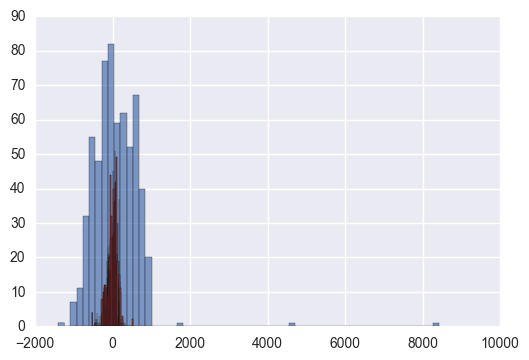

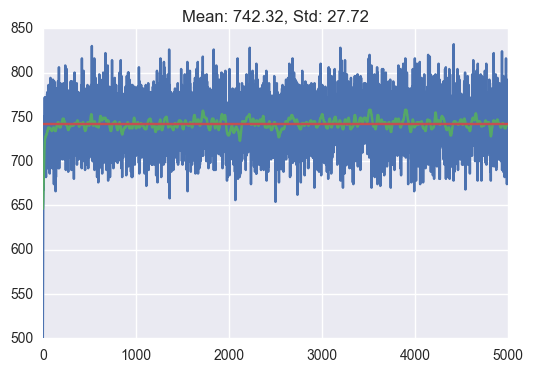

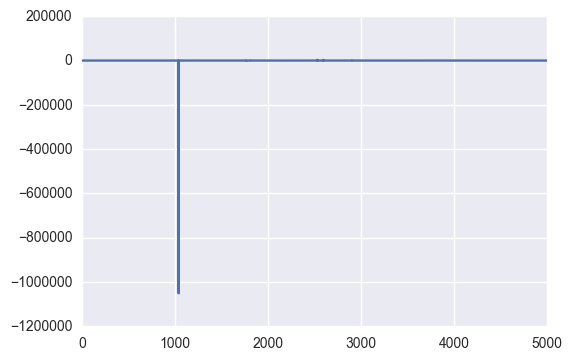

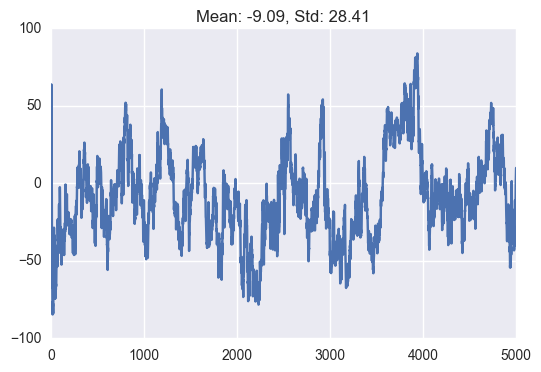

In [59]:
agents = np.array([np.random.randint(-1000, 1000) for i in range(num_init_agents)])
num_agents = num_init_agents
kappa = 1.0 / (3 * num_init_agents)
epsilon = 1.0/ (3 * np.max(agents **2))

n_max = 5000
population_mass = [agents.size]
mean_pheno = [agents.mean()]
median_pheno = [np.median(agents)]
for n in range(n_max):
    new_agents = []
    removed_index = []

    for i in range(num_agents):
        dn = kappa * num_agents + epsilon * (agents[i] ** 2)
        bn = gamma
        rand = np.random.rand()
        if rand < dn:
            removed_index.append(i)
        elif rand >= dn and rand < dn + bn:
            new_agents.append(agents[i])
    agents = np.delete(agents, removed_index, axis=0)
    agents = np.append(agents, new_agents)
    num_agents = num_agents - len(removed_index) + len(new_agents)
    assert num_agents == agents.size
    agents = agents + rv.rvs(agents.size)
    population_mass.append(agents.size)
    mean_pheno.append(agents.mean())
    median_pheno.append(np.median(agents))
    
    if n % (n_max //2) == 1:
        plt.hist(agents, bins = agents.size/10, alpha = 0.7)

print agents.size, agents.mean(), agents.max(), np.median(agents)
hist = plt.hist(agents, bins = agents.size / 10)
plt.figure()
time_axis = range(n_max +1)
plt.plot(time_axis, population_mass)
plt.plot(time_axis, scipy.ndimage.gaussian_filter1d(population_mass, sigma=np.log(n_max)))
plt.plot([0, n_max], np.ones(2) * np.mean(population_mass))
plt.title("Mean: %.2f, Std: %.2f" % (np.mean(population_mass), np.std(population_mass)))
plt.figure()
plt.plot(time_axis, mean_pheno)
plt.figure()
plt.plot(time_axis, median_pheno)
plt.title("Mean: %.2f, Std: %.2f" % (np.mean(median_pheno), np.std(median_pheno)))


In [635]:
def plot_series(series, ax=None, alpha=1, title='', color=None):
    ax.plot(series, alpha=alpha, color=color)
    if title:
        ax.set_title("%s \nMean: %.2f Median: %.2f Std: %.2f" 
                     % (title, np.mean(series), np.median(series), np.std(series)))
    return ax

def rvs_generator(n, p, h):
    rand_vec = np.random.rand(n)
    p_left = p / (1.0 + h)
    p_right = p * h / (1.0 + h)
    move_prob = np.greater(p_left + p_right, rand_vec)
    move_left_prob = np.greater(p_left, rand_vec)
    return move_prob - 2 * move_prob * move_left_prob

def get_equilibrium_time2(series, min_points = 50):
    series = np.array(series)
    mean = np.mean(series)
    deviation = np.sqrt((series - mean)**2)
    mean_deviation = np.mean(deviation)
    std_deviation = np.std(deviation)
    for i in range(len(series) - min_points):
        window = deviation[i: i + min_points]
        window_mean = np.mean(window)
        #print i, window_mean, mean_deviation, std_deviation
        if np.abs(window_mean - mean_deviation) < std_deviation:
            print "Equitime: %i" %i
            return i + min_points
    return min_points
def get_equilibrium_time(series, min_points = 50):
    series = np.array(series)
    mean = np.mean(series)
    std = np.std(series)
    for i in range(len(series)):
        window_mean = np.mean(series[:i])
        if abs(window_mean - mean) < 0.5 * std:
            return max(i, min_points)
    return min_points
        
    deviation = np.sqrt((series - mean)**2)
    mean_deviation = np.mean(deviation)
    std_deviation = np.std(deviation)
    for i in range(len(series) - min_points):
        window = deviation[i: i + min_points]
        window_mean = np.mean(window)
        #print i, window_mean, mean_deviation, std_deviation
        if np.abs(window_mean - mean_deviation) < std_deviation:
            print "Equitime: %i" %i
            return i + min_points
    return min_points
        
def compute_bins(series):
    """
    Friedman-Diaconis rule of thumb for histogram bin number
    """
    iqr = stats.iqr(series)
    n = series.size
    bins = (series.max() - series.min()) / (2 * iqr * n ** (-1/3.0))
    return int(bins)
    
    
class Simulate(object):
    def __init__(self, num_init_agents=1000, birth_rate=None, death_rate=None, selection_penalty=None, 
                 num_generation=None, rv_sample_generator=None, init_dist=None):
        self.birth_rate = birth_rate
        self.death_rate = death_rate
        self.selection_penalty = selection_penalty
        self.num_generation = num_generation
        self.rv_sample_generator = rv_sample_generator
        self.num_init_agents = num_init_agents
        self.init_dist = init_dist
        self.realisations = []
    
    def add_realisation(self, n):
        for i in range(n):
            np.random.seed(int(time.time()))
            self.realise()
        return 
    
    def realise(self):
        if type(self.init_dist) != np.ndarray:
            agents = np.zeros(self.num_init_agents)
        else:
            agents = self.init_dist
        population_n = [agents.size]
        pheno_mean = [agents.mean()]
        pheno_median = [np.median(agents)]
        birth_rate = self.birth_rate
        for n in range(self.num_generation): # first generation already initiated
            new_agents = []
            removed_index = []
            agents = agents + self.rv_sample_generator(agents.size)
            for agent_index in range(agents.size):
                death_rate = self.death_rate * agents.size + self.selection_penalty * (agents[agent_index] ** 2)
                uniform_rand = np.random.rand()
                if uniform_rand < death_rate:
                    removed_index.append(agent_index)
                elif uniform_rand >= death_rate and uniform_rand < (death_rate + birth_rate):
                    new_agents.append(agents[agent_index])
           
            agents = np.delete(agents, removed_index, axis=0)
            agents = np.append(agents, new_agents)
            population_n.append(agents.size)
            pheno_mean.append(agents.mean())
            pheno_median.append(np.median(agents))
        self.realisations.append({"agents":agents, "population_n":population_n,
                                 "pheno_mean":pheno_mean, "pheno_median":pheno_median})
        #print self.realisations[0]["agents"]
        #print self.realisations[0]["population_n"]

        
    def report_realisation(self, realisation):
        fig, axes = plt.subplots(4, 1, figsize = (7, 4 * 7))
        agents = realisation["agents"]
        population_n = realisation["population_n"]
        equi_mean = agents.mean()
        equi_num_agents = agents.size
        equi_median = np.median(agents)
        equi_std = np.std(agents)
        if equi_num_agents == 0:
            extinction_time = np.max(np.array(population_n).nonzero()) +1
            print "Extinction occurred at generation: %i" % extinction_time
        else:
            axes[0].hist(realisation["agents"], bins=compute_bins(realisation["agents"]))
            axes[0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            xmin, xmax = axes[0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std) * equi_num_agents)
        plot_series(population_n, ax=axes[1], title="nth generation population size")
        axes[1].plot(axes[1].get_xlim(), np.ones(2) * np.mean(population_n))
        plot_series(realisation["pheno_mean"], ax=axes[2], title="nth generation phenotype mean")
        plot_series(realisation["pheno_median"], ax=axes[3], title="nth generation phenotype median")
        return fig, axes
        
    def report_avg_realisation(self):
        num_realisation = len(self.realisations)
        print "Number of realisations: %i" % num_realisation
        if num_realisation == 0:
            return 
        elif num_realisation == 1:
            return self.report_realisation(self.realisations[0])
        agents_n = []
        extinction_time = []
        for item in self.realisations:
            if 0 in item['population_n']:
                extinction_time.append(item['population_n'].index(0))
            else:
                agents_n.append(item["agents"])
        
        num_extinction = len(extinction_time)
        if num_extinction > 0:
            p_extinct = float(num_extinction) / num_realisation
            avg_ext_time = np.mean(extinction_time)
            print ("%i extinction event out of %i realisation\np_extinct ~ %.2f\navg_ext_time: %.2f" 
                   % (num_extinction, num_realisation,p_extinct, avg_ext_time))
        fig, axes = plt.subplots(4, 2, figsize = (7 * 2, 4 * 7))
        if agents_n:
            agents_n = np.concatenate(agents_n)
            equi_mean = agents_n.mean()
            equi_num_agents = agents_n.size
            equi_median = np.median(agents_n)
            equi_std = np.std(agents_n)
            equi_iqr = stats.iqr(agents_n)
            
            axes[0][0].hist(agents_n, bins=compute_bins(agents_n))
            axes[0][0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            sns.distplot(agents_n, ax=axes[0][1])
            xmin, xmax = axes[0][0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0][1].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std), color='g')
            axes[0][1].plot(ax0_xaxis, stats.cauchy.pdf(ax0_xaxis, loc=equi_median, scale=equi_iqr), color='r')
        
        
        mult_population_n = np.concatenate([[item["population_n"]] for item in self.realisations])
        eq_time_pop = get_equilibrium_time(gaussian_filter1d(mult_population_n.mean(axis=0), sigma=5))
        plot_series(mult_population_n.transpose(), alpha=0.3, ax=axes[1][0])
        plot_series(mult_population_n.mean(axis=0), alpha=1, color='r', ax=axes[1][0], 
                    title='nth generation population')
        plot_series(mult_population_n.transpose()[:eq_time_pop, :], alpha=0.3, ax=axes[1][1])
        plot_series(mult_population_n.mean(axis=0)[:eq_time_pop], alpha=1, color='r', ax=axes[1][1], 
                    title='nth generation population (cut off at estimated equilibrium time: gen %i)'%eq_time_pop)
        
        mult_pheno_mean = np.concatenate([[item["pheno_mean"]] for item in self.realisations])
        eq_time_mean = get_equilibrium_time(gaussian_filter1d(mult_pheno_mean.mean(axis=0), sigma=5))
        plot_series(mult_pheno_mean.transpose(), alpha=0.3, ax=axes[2][0])
        plot_series(mult_pheno_mean.mean(axis=0), alpha=1, color='r', ax=axes[2][0], 
                    title='nth generation phenotype mean')
        plot_series(mult_pheno_mean.transpose()[:eq_time_mean, :], alpha=0.3, ax=axes[2][1])
        plot_series(mult_pheno_mean.mean(axis=0)[:eq_time_mean], alpha=1, color='r', ax=axes[2][1], 
                    title='nth generation phenotype mean(cut off at estimated equilibrium time: gen %i)'%eq_time_mean)
        
        
        mult_pheno_median = np.concatenate([[item["pheno_median"]] for item in self.realisations])
        eq_time_median = get_equilibrium_time(gaussian_filter1d(mult_pheno_median.mean(axis=0), sigma=5))
        plot_series(mult_pheno_median.transpose(), alpha=0.3, ax=axes[3][0])
        plot_series(mult_pheno_median.mean(axis=0), alpha=1, color='r', ax=axes[3][0], 
                    title='nth generation phenotype median')
        plot_series(mult_pheno_median.transpose()[:eq_time_median, :], alpha=0.3, ax=axes[3][1])
        plot_series(mult_pheno_median.mean(axis=0)[:eq_time_median], alpha=1, color='r', ax=axes[3][1], 
                    title='nth generation phenotype median(cut off at estimated equilibrium time: gen %i)'%eq_time_median)
        return fig, axes


In [670]:
sim_finite2 = Simulate(num_init_agents=10, 
                    birth_rate=0.8, 
                    death_rate=0.001, 
                    selection_penalty = 0.0001,
                    num_generation=1000, 
                    rv_sample_generator=lambda n: rvs_generator(n, 0.9, 1), 
                    init_dist=None)


Number of realisations: 10


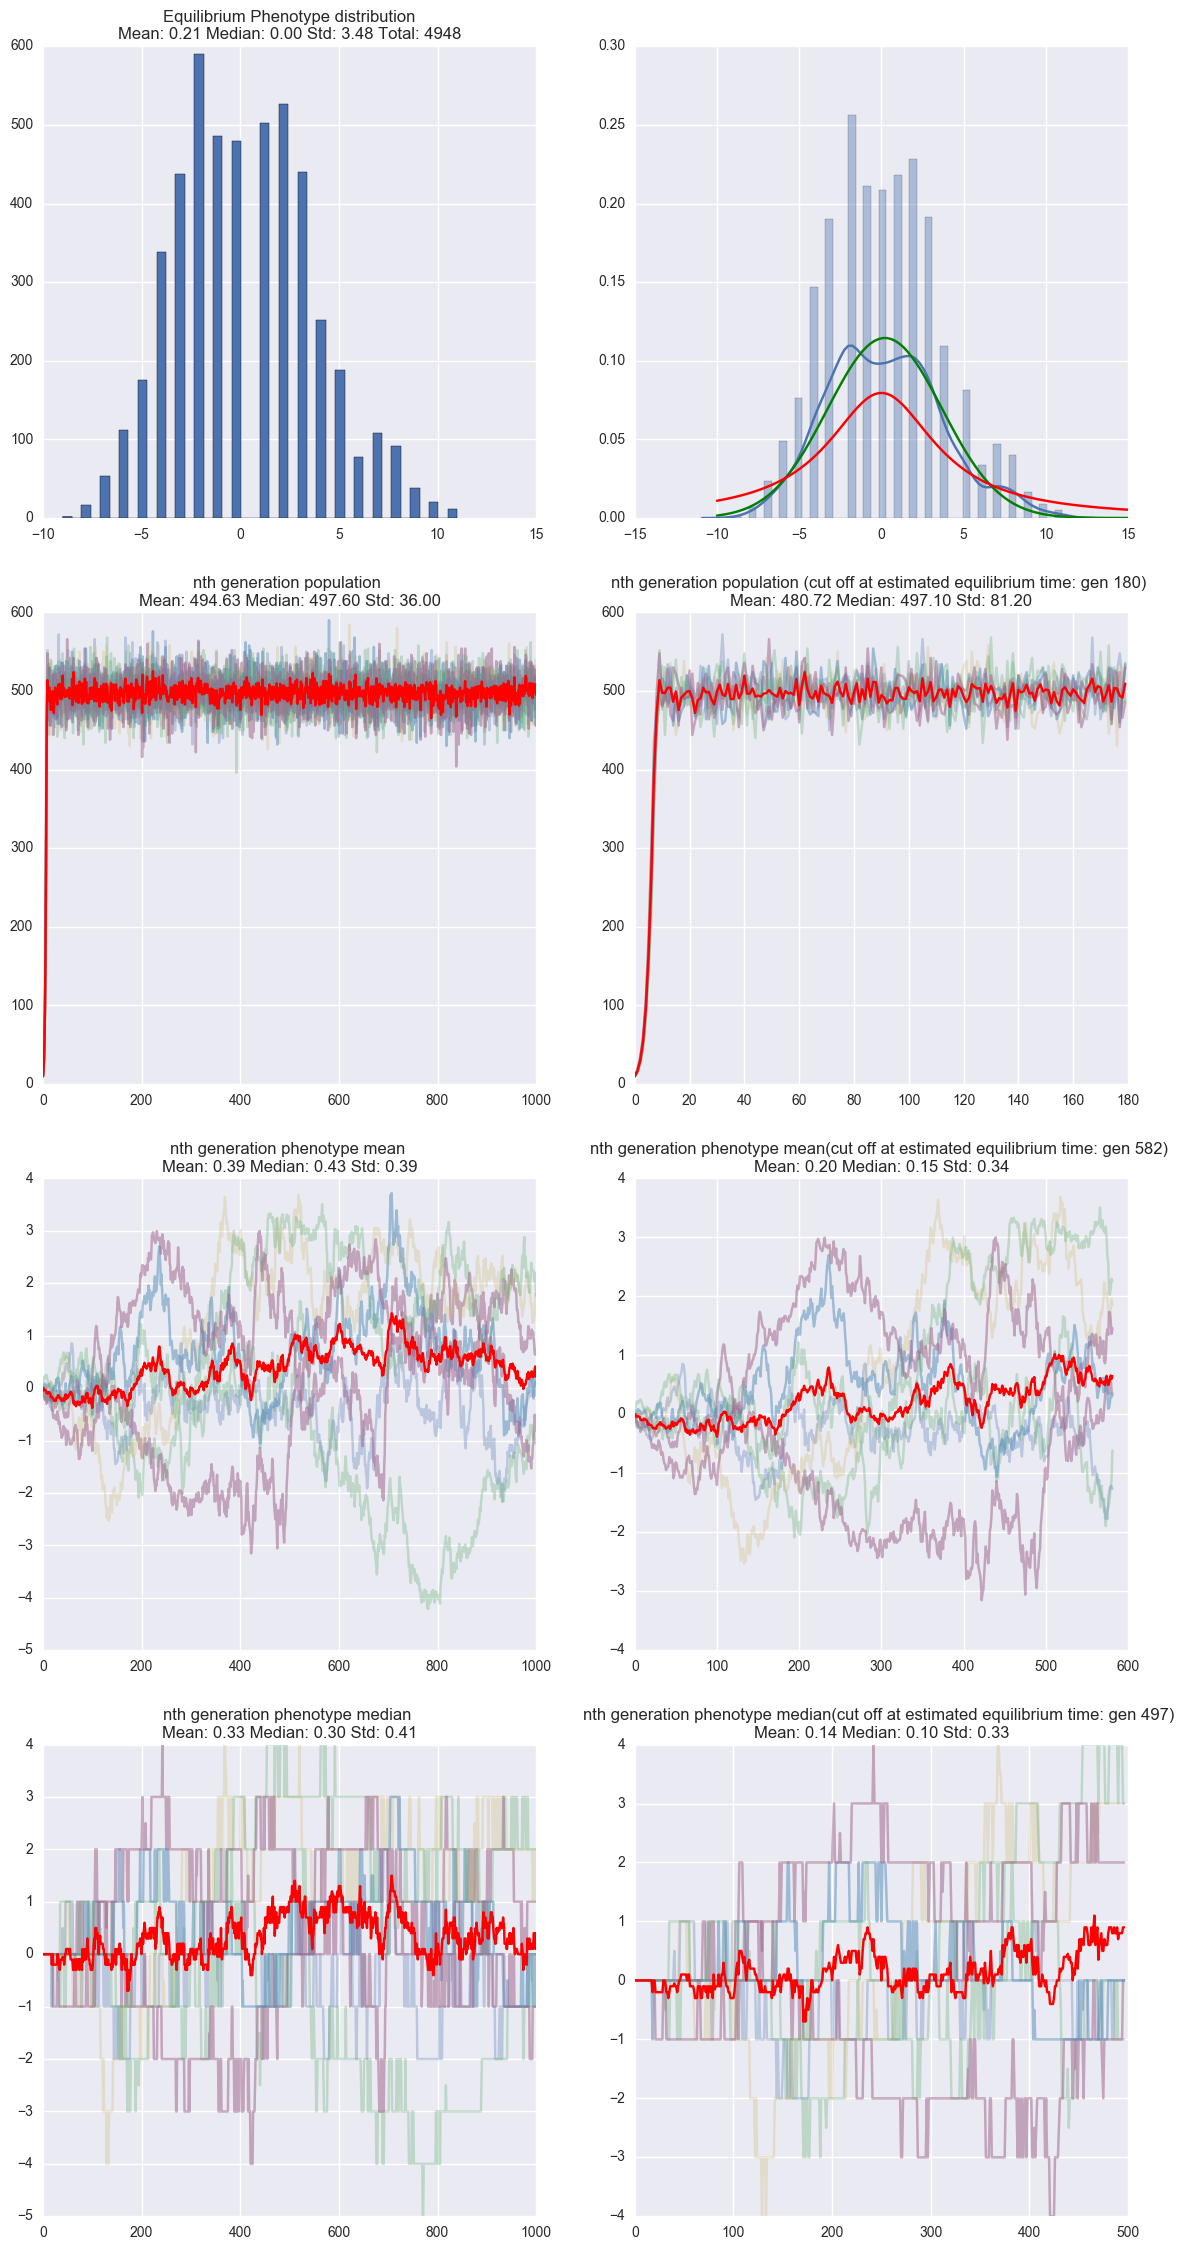

In [671]:
sim_finite2.add_realisation(10)
a = sim_finite2.report_avg_realisation()

In [672]:
cauchy_sim = Simulate(num_init_agents=10, 
                    birth_rate=0.8, 
                    death_rate=0.001, 
                    selection_penalty = 0.0001,
                    num_generation=1000, 
                    rv_sample_generator=stats.cauchy(loc=0, scale=20).rvs, 
                    init_dist=None)

Number of realisations: 10


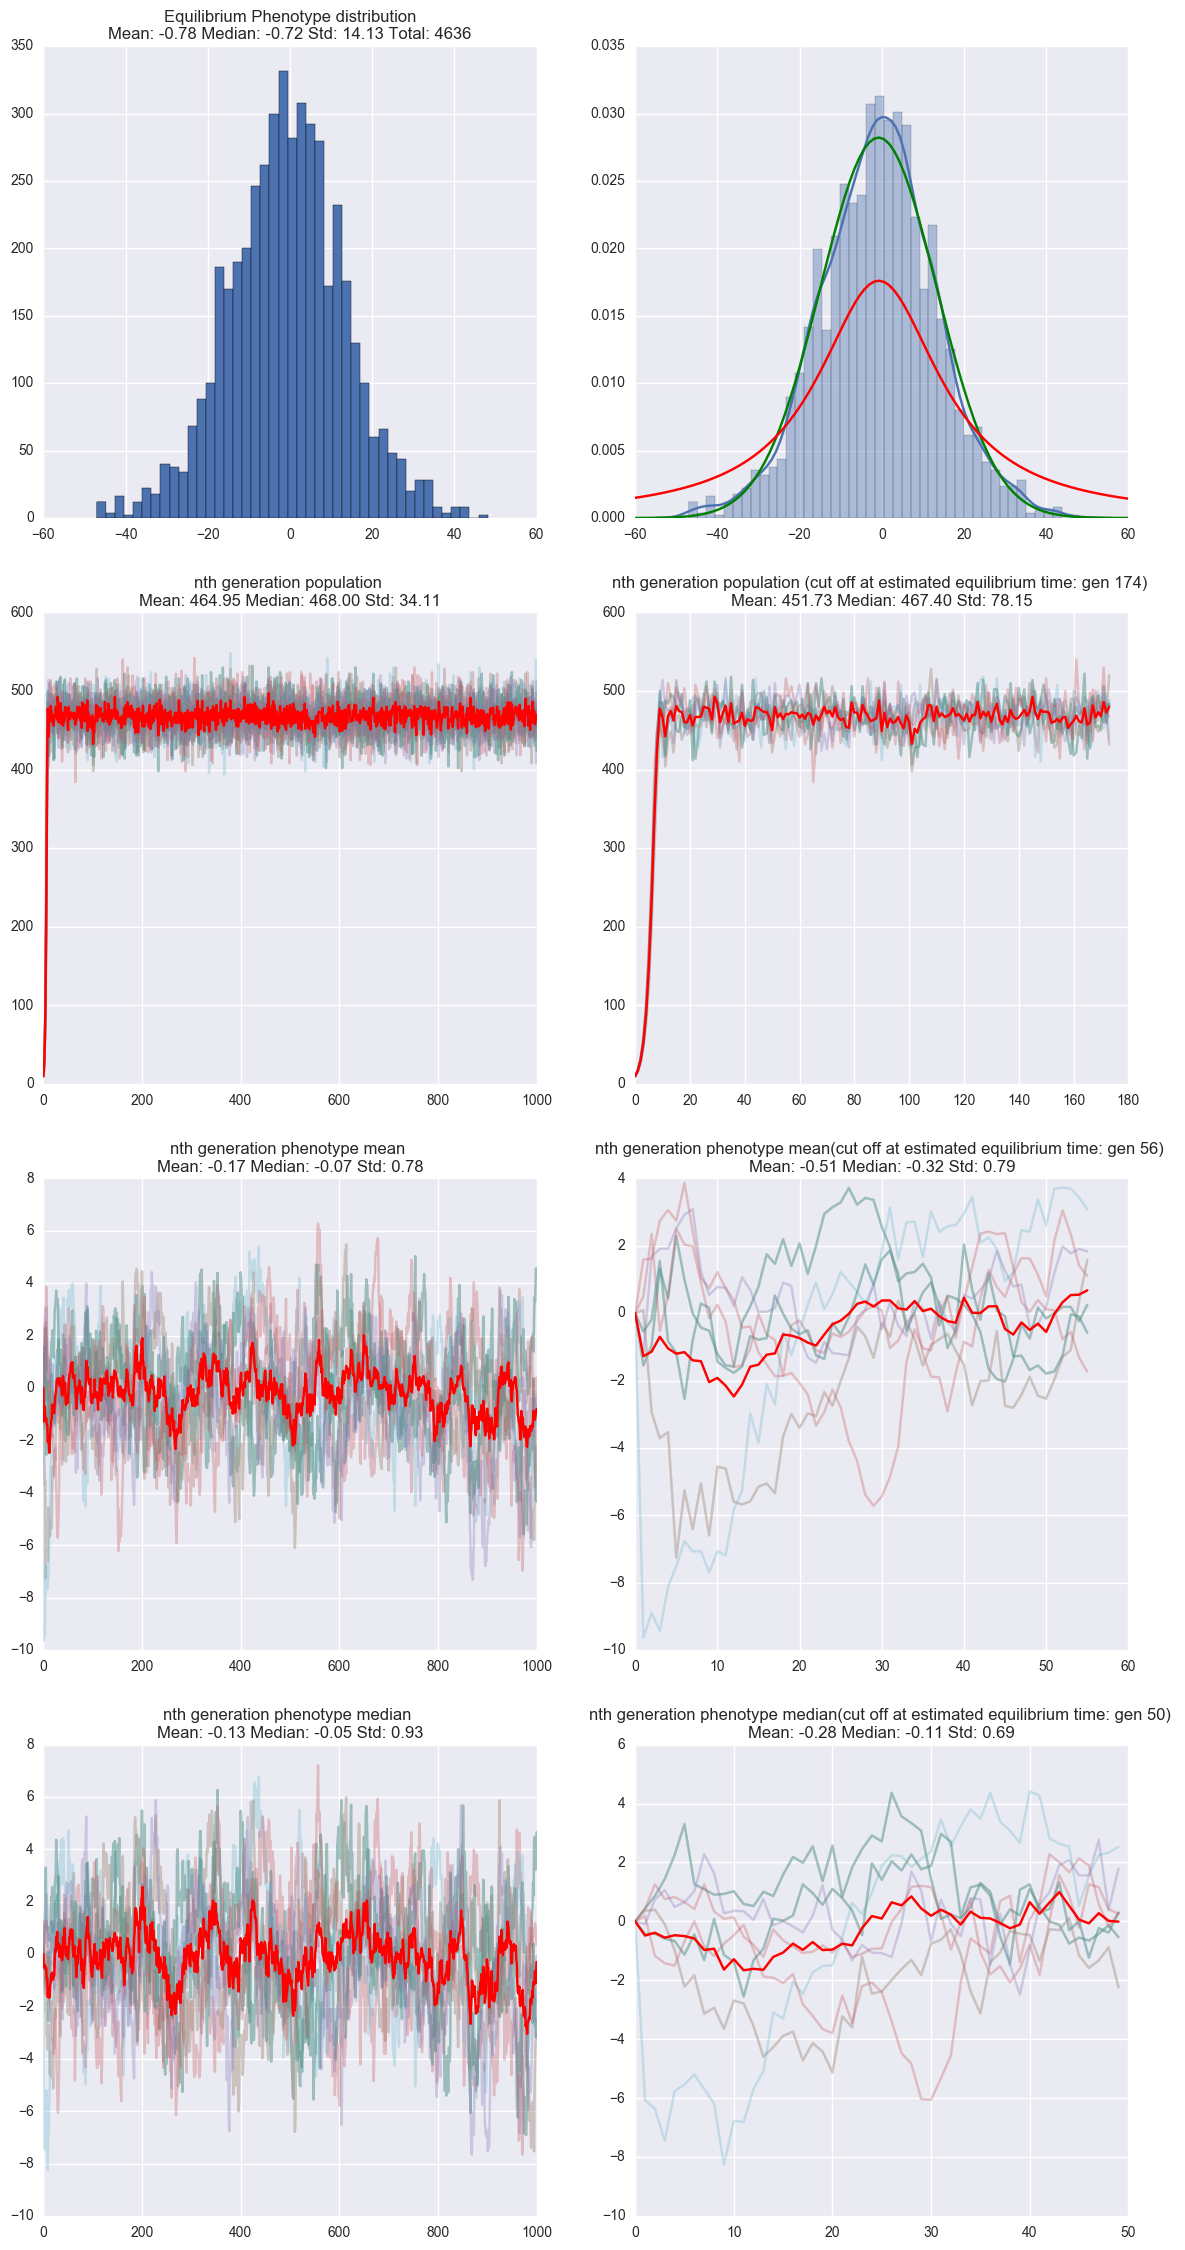

In [673]:
cauchy_sim.add_realisation(10)
a = cauchy_sim.report_avg_realisation()

Number of realisations: 10


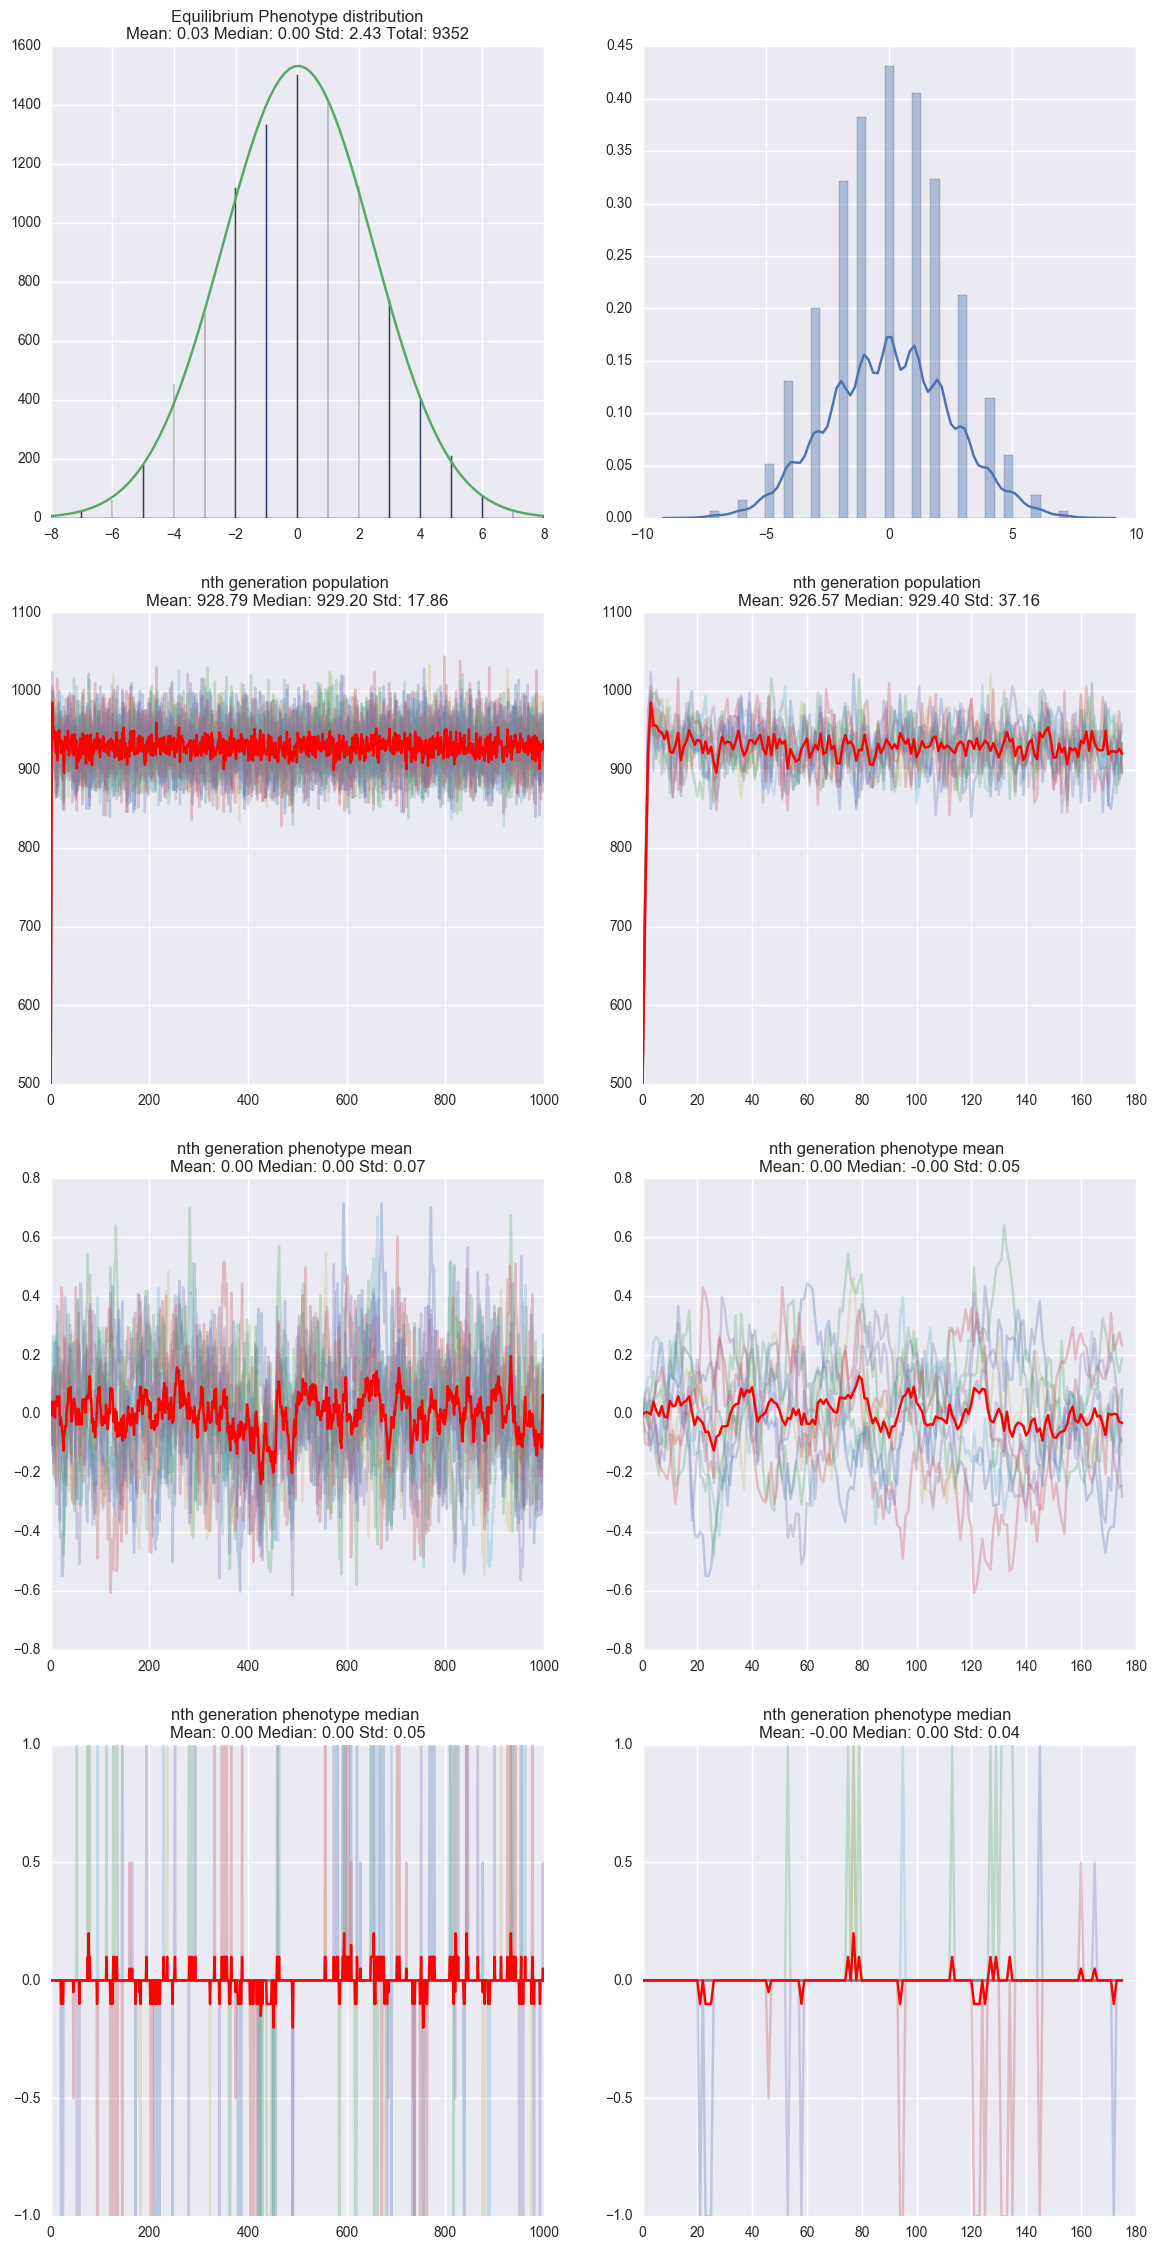

In [512]:
sim_finite = Simulate(num_init_agents=500, 
                    birth_rate=0.8, 
                    death_rate=0.0005, 
                    selection_penalty = 0.005,
                    num_generation=1000, 
                    rv_sample_generator=lambda n: rvs_generator(n, 0.9, 1), 
                    init_dist=None)
sim_finite.add_realisation(10)
a = sim_finite.report_avg_realisation()

Number of realisations: 30


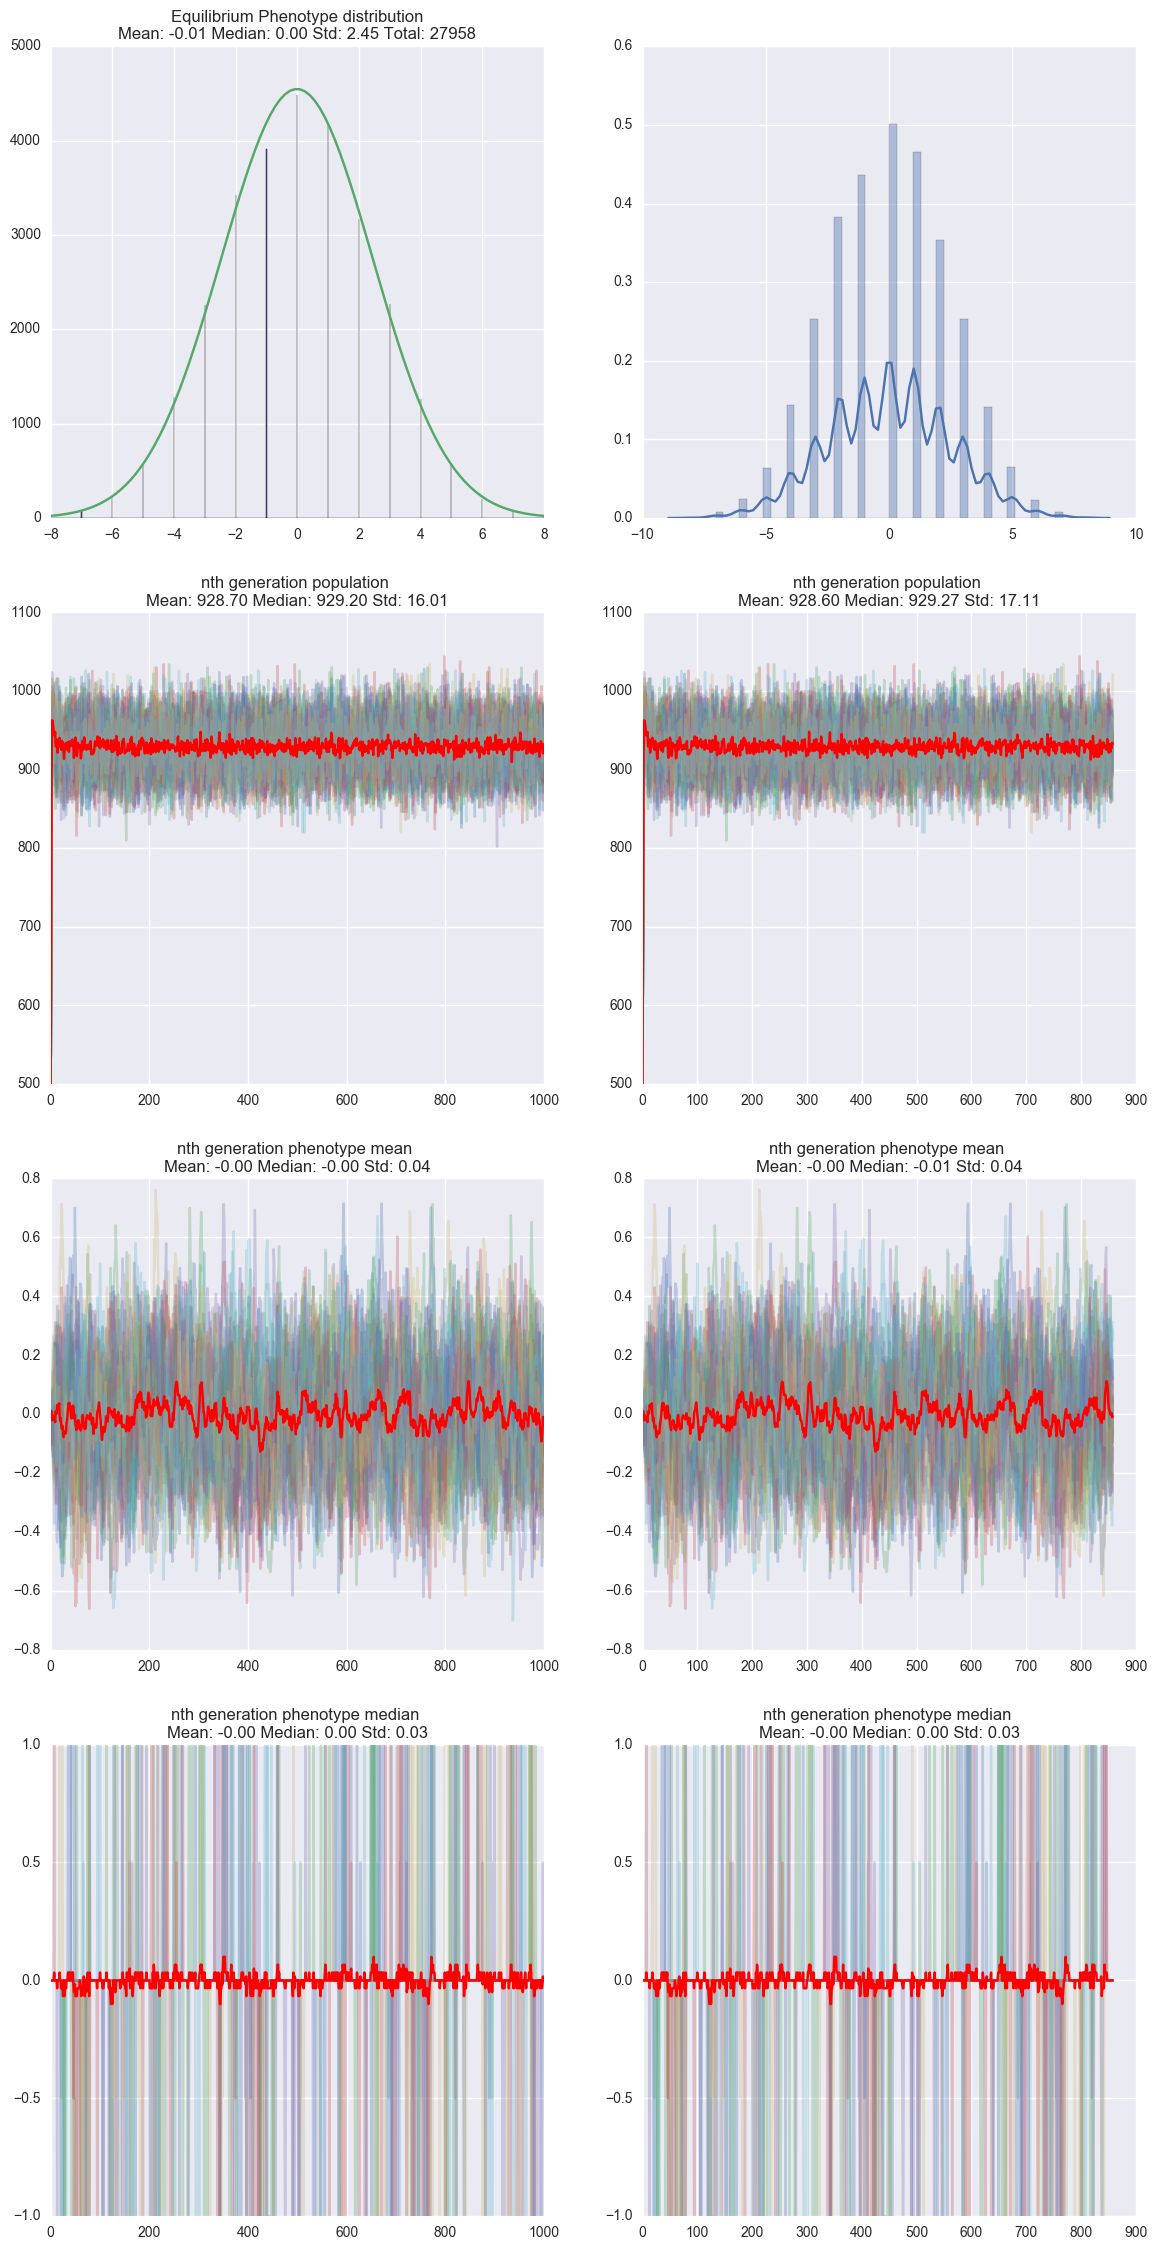

In [514]:
sim_finite.add_realisation(10)
b = sim_finite.report_avg_realisation()

3.76568880544 3428


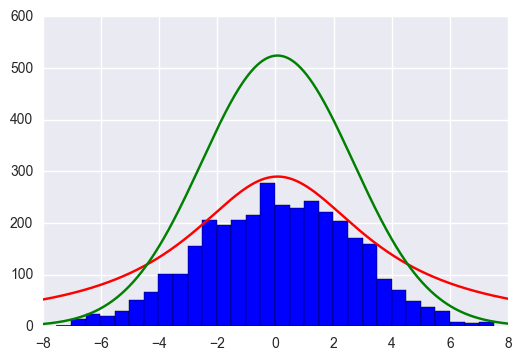

In [617]:
x = np.linspace(-8, 8, num=1000)

cauch_agents = np.concatenate([item["agents"] for item in cauchy_sim.realisations])
realisation = cauchy_sim.realisations[0]["agents"]
iqr = stats.iqr(cauch_agents)
total = sum(item["agents"].size for item in cauchy_sim.realisations)
assert total == cauch_agents.size
print iqr, total
plt.plot(x, stats.cauchy.pdf(x, loc=0.07, scale=iqr) * cauch_agents.size, color='r')
plt.plot(x, stats.norm.pdf(x, loc=0.07, scale=2.61) * cauch_agents.size, color='g')
#plt.figure()
x0 = plt.hist(cauch_agents, color='b', 
              bins=int((cauch_agents.max() - cauch_agents.min()) / (2 * iqr * cauch_agents.size ** (-1/3.0))))

In [173]:
test_sim = Simulate(num_init_agents=100, 
                    birth_rate=gamma, 
                    death_rate=kappa, 
                    selection_penalty = epsilon,
                    num_generation=5000, 
                    rv_sample_generator=stats.cauchy().rvs, 
                    init_dist=None)

#test_sim.realise()
test_sim.add_realisation(10)
#test_sim.report_realisation(test_sim.realisations[0])

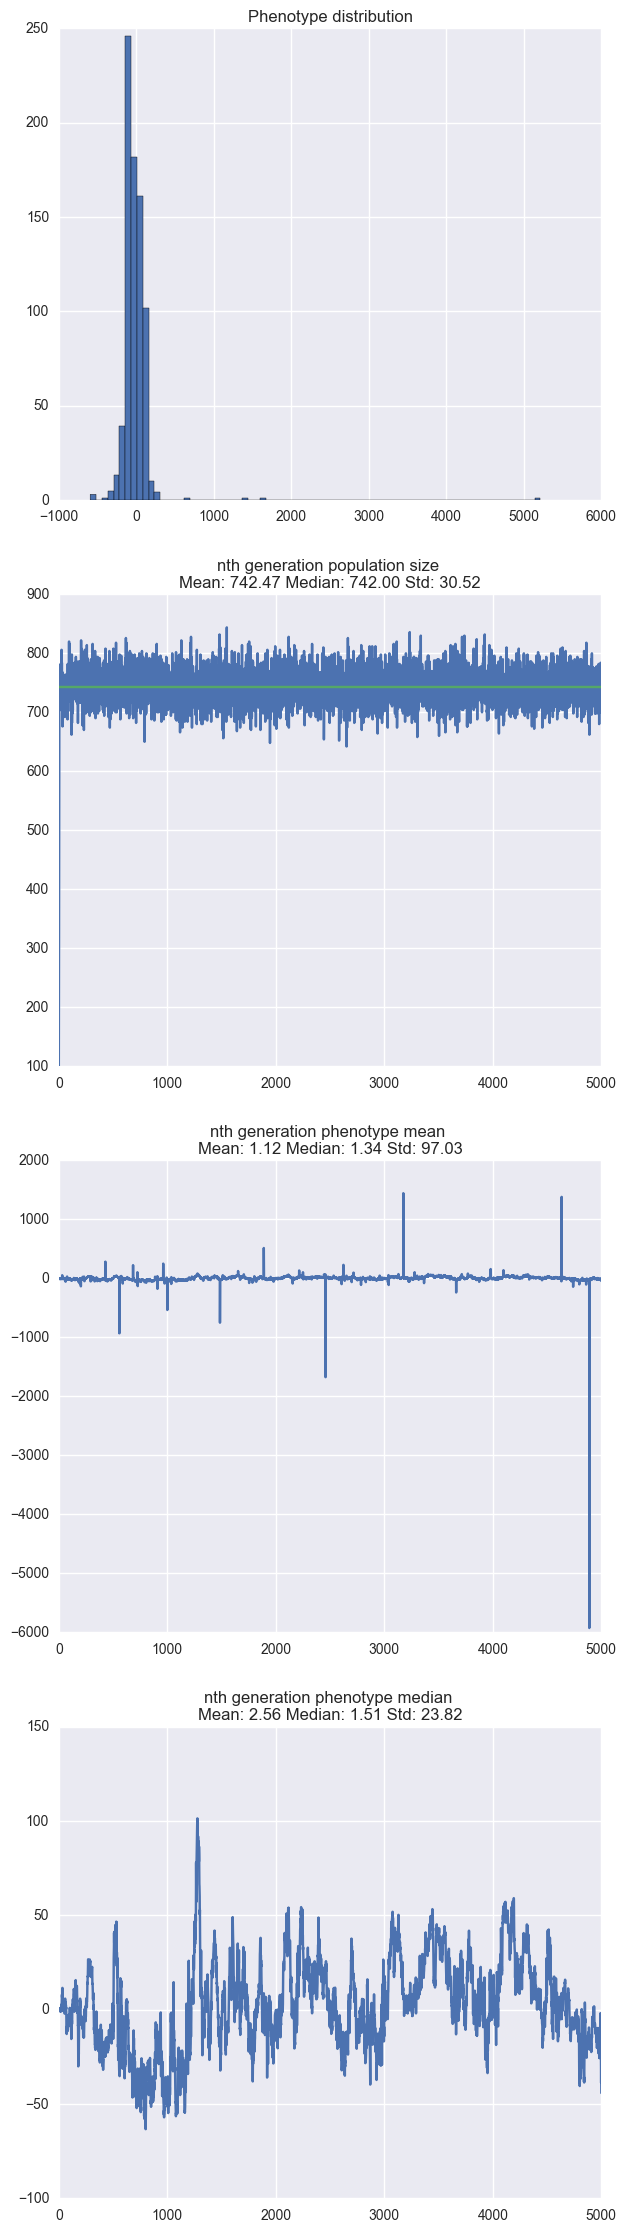

In [238]:
test_sim.report_realisation(test_sim.realisations[3])

(array([   1.,    1.,    0.,    1.,    4.,   30.,  953.,    7.,    2.,    1.]),
 array([-1223.18504071, -1026.8394242 ,  -830.49380768,  -634.14819116,
         -437.80257465,  -241.45695813,   -45.11134161,   151.2342749 ,
          347.57989142,   543.92550794,   740.27112445]),
 <a list of 10 Patch objects>)

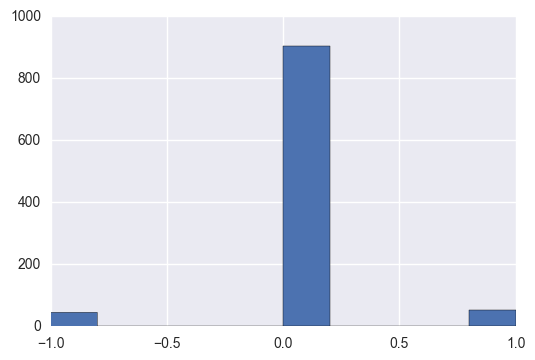

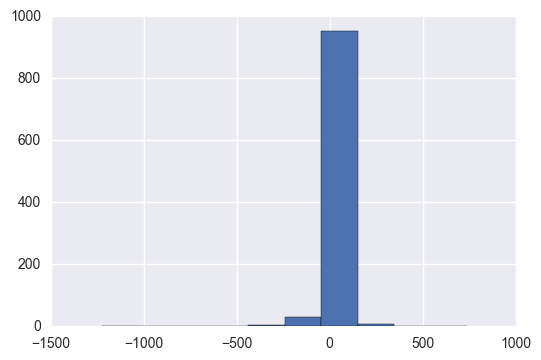

In [679]:
plt.hist(rvs_generator(1000, 0.1, 1))
plt.figure()
plt.hist(stats.cauchy(scale=5).rvs(1000))

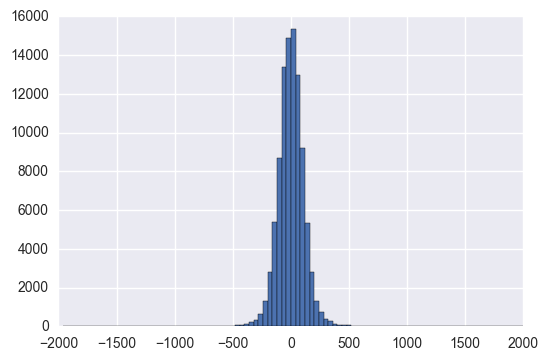

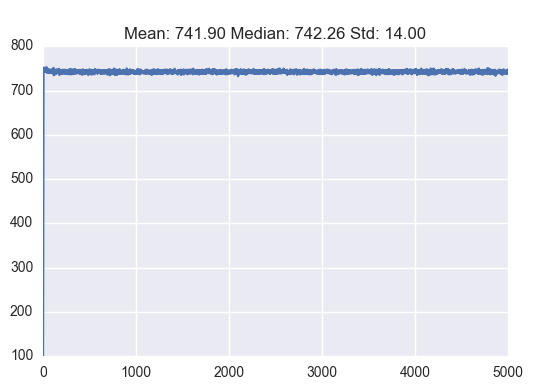

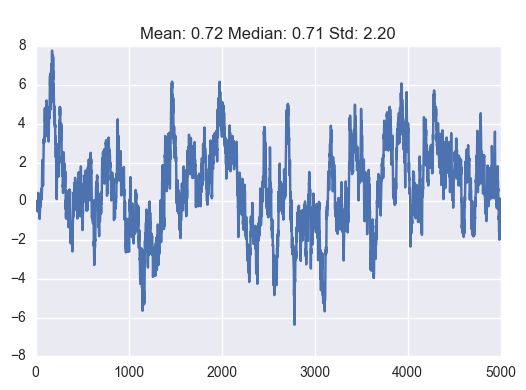

In [186]:
agt_n = np.concatenate([item["agents"] for item in test_sim.realisations])
x = plt.hist(agt_n, bins=100, range=(-2000, 2000))

plt.figure()
pop_n = np.concatenate([[item["population_n"]] for item in test_sim.realisations])
mean_pop_n = np.mean(pop_n, axis=0)
plot_series(mean_pop_n, plt.subplot(111))


plt.figure()
median_n = np.concatenate([[item["pheno_median"]] for item in test_sim.realisations])
mean_median_n = np.mean(median_n, axis=0)
plot_series(mean_median_n, plt.subplot(111))

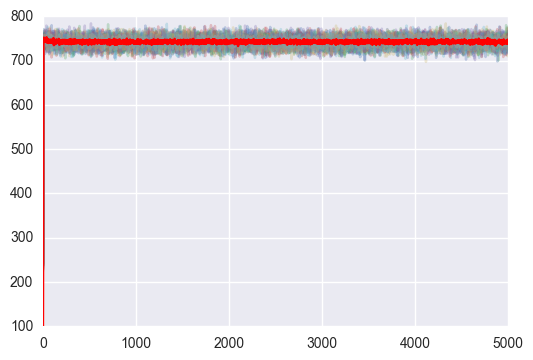

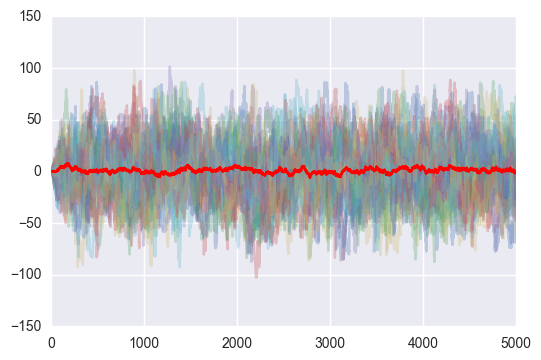

In [188]:
N = 5000
for item in test_sim.realisations[:30]:
    plt.plot(range(N), gaussian_filter1d(item["population_n"][:N], 2), alpha=0.3)
plt.plot(range(N), mean_pop_n[:N], color="r")

plt.figure()
for item in test_sim.realisations[:30]:
    plt.plot(range(N), item["pheno_median"][:N], alpha=0.3)
plt.plot(range(N), mean_median_n[:N], color="r")

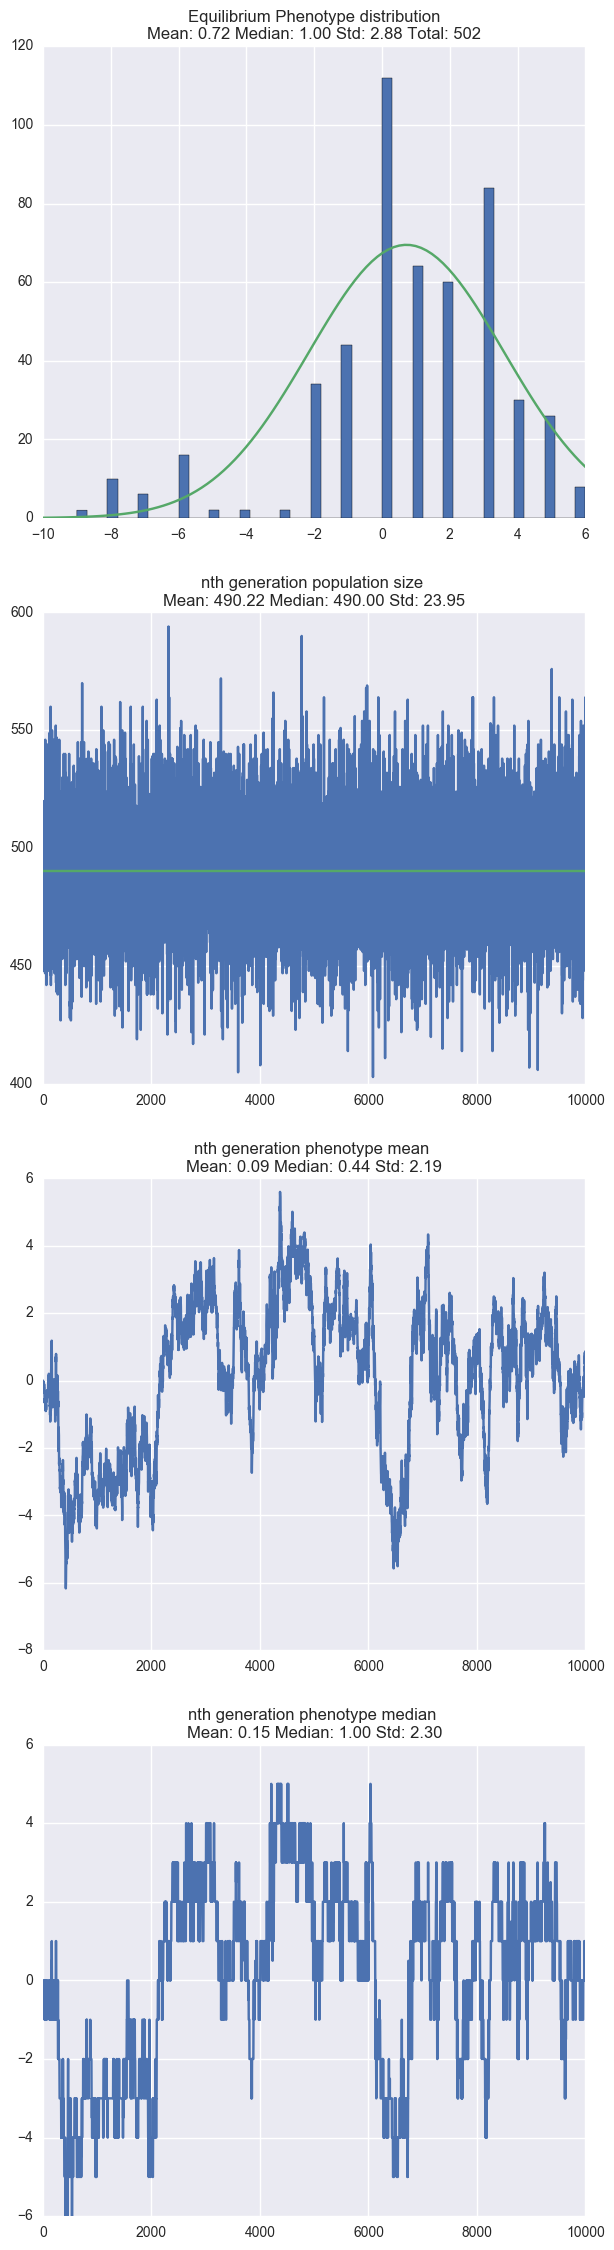

In [414]:
epsilon = 0.0001
sim2 = Simulate(num_init_agents=500, 
                    birth_rate=0.5, 
                    death_rate=0.001, 
                    selection_penalty = epsilon,
                    num_generation=10000, 
                    rv_sample_generator=lambda n: rvs_generator(n, 0.1, 1), 
                    init_dist=None)

sim2.add_realisation(1)
sim2.report_realisation(sim2.realisations[0])

[ 95.  94.  94.  94.  94.  94.  93.  93.  92.  91.  90.  89.  89.  89.  89.
  89.  90.  90.  90.  90.]


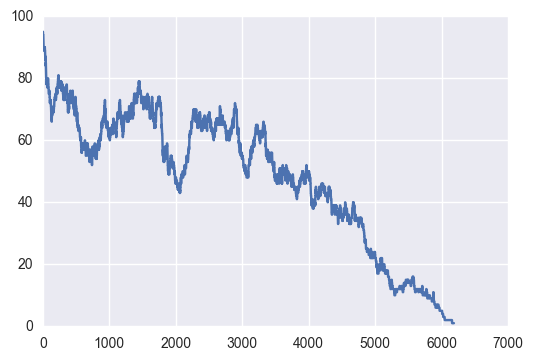

In [237]:
P = 100  # maximum population size
a = .005  # birth rate
b = .005  # death rate

T = 100000
x = np.zeros(T)
x[0] = np.random.randint(0, 100)

for t in range(T - 1):
    if 0 < x[t] < P-1:
        # Is there a birth?
        birth = np.random.rand() <= a*x[t]
        # Is there a death?
        death = np.random.rand() <= b*x[t]
        # We update the population size.
        x[t+1] = x[t] + 1*birth - 1*death
    # The evolution stops if we reach $0$ or $N$.
    else:
        x[t+1] = x[t]

print x[:20]
plt.plot(x[x.nonzero()]);